# Load and have initial look at data

In [81]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Importing data

## Importing Water_Main_Breaks dataset

In [43]:
import pandas as pd
import pandas as pd
import json
from urllib.request import urlopen

In [44]:
def create_df_all_queries(query_url):
    result_offset = 0
    df_new_query_length = 2000
    loop_counter = 0
    while df_new_query_length == 2000:
        query_url_result_offset = query_url + '&resultOffset='+str(result_offset)
        #print('loop started')
        new_query_data = urlopen(query_url_result_offset).read()
        new_query_raw_json = json.loads(new_query_data)
        new_query_formatted_json = [feature['attributes'] for feature in new_query_raw_json['features']]
        df_new_query = pd.DataFrame(new_query_formatted_json)
        df_new_query_length = df_new_query.shape[0]
        if loop_counter < 1:
            #print('if statement entered')
            df_main = df_new_query
            #print('if statement finished')
            #print(df_main.shape)
        else:
            #print('else statement entered')
            df_main = pd.concat([df_main, df_new_query])
           # print(df_main.shape)
           # print('else statement finished')
        #print(loop_counter)
        loop_counter += 1
        #print(df_new_query_length)
        #print(df_main.tail())
        #if loop_counter > 8:
        #    break
        result_offset += 2000
       # print('loop finished')
    return df_main

### Creating the combined Water Mains DataFrame object instance from create_df_all_queries

In [45]:
water_mains_url = 'https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Water_Mains/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
water_main_breaks_url = 'https://services1.arcgis.com/qAo1OsXi67t7XgmS/arcgis/rest/services/Water_Main_Breaks/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'

df_w = create_df_all_queries(water_mains_url)
df_b = create_df_all_queries(water_main_breaks_url)

In [53]:
print([df_b.shape, df_b.OBJECTID.unique.shape[0]])
df_b.head(3)

AttributeError: 'function' object has no attribute 'length'

In [63]:
print([df_w.shape, df_w.OBJECTID.unique], \nl])
df_w.head(3)

SyntaxError: unexpected character after line continuation character (<ipython-input-63-48adfda5c97b>, line 1)

### Checking that the combined Water Mains dataframe 'df_w' contains only unique entries

In [40]:
df_w.WATMAINID.unique

<bound method Series.unique of 0       11270
1       82562
2        6890
3       82564
4       10080
        ...  
772    136394
773    136434
774    136436
775    136438
776    136440
Name: WATMAINID, Length: 14777, dtype: int64>

# Data Cleaning (Goal: Tidy Data)
Having looked at the literature on predicting watermain failures, I decided to implement the data structure from Harvey et. al. Their model used the most similar features to the ones we have available here. The observational unit is break instance, with a '# previous breaks' feature seperating for the ML algorithm break instances of the same pipe. Let us now wrangle the dataset to that format.

Harvey et. al. study:
https://www.researchgate.net/publication/273369340_Predicting_the_Timing_of_Water_Main_Failure_Using_Artificial_Neural_Networks

In [73]:
df_breaks.columns = df_breaks.columns.str.lower()
df_watmains.columns = df_watmains.columns.str.lower()

In [74]:
# remove break break instances from df_breaks that dont have corresponding entries in df_watmains
print(len(df_breaks))
df_breaks = df_breaks[df_breaks.rel_watmainid.isin(df_watmains.watmainid) == True]
print(len(df_breaks))

2346
2007


In [75]:
# move relevant data from df_watmains to df_breaks
df_watmains.set_index('watmainid', inplace = True)
df_breaks['diameter'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['pipe_size'])
df_breaks['material'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['material'])
df_breaks['lined_material'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['lined_material'])
df_breaks['length'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['shape__length'])
df_breaks['lined'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['lined'])
df_breaks['lined_date'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['lined_date'])
df_breaks['installation_date'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['installation_date'])
df_breaks['criticality'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['criticality'])
df_breaks['pressure_zone'] = df_breaks.rel_watmainid.apply(lambda x: df_watmains.loc[x]['pressure_zone'])

In [76]:
df_breaks.columns

Index(['x', 'y', 'objectid', 'watmainbreakid', 'update_by', 'category',
       'status', 'work_order', 'incident_date', 'break_apparent_cause',
       'break_nature', 'anode_installed', 'soil_type', 'main_depth',
       'rel_watmainid', 'rel_watservicepipeid', 'nearest_address', 'diameter',
       'material', 'lined_material', 'length', 'lined', 'lined_date',
       'installation_date', 'criticality', 'pressure_zone'],
      dtype='object')

In [77]:
import pandas_profiling

pandas_profiling.ProfileReport(df_breaks)

Number of variables,27
Number of observations,2007
Total Missing (%),23.2%
Total size in memory,423.4 KiB
Average record size in memory,216.0 B
Numeric,7
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [78]:
#format dates to pandas datetime objects
try:
    df_breaks['lined_date'] = pd.to_datetime(df_breaks['lined_date'].str.slice(0,-14), format='%Y-%m-%d')
    df_breaks['installation_date'] = pd.to_datetime(df_breaks['installation_date'].str.slice(0,-14), format='%Y-%m-%d')
    df_breaks['incident_date'] = pd.to_datetime(df_breaks['incident_date'].str.slice(0,-14), format='%Y-%m-%d')
except:
    pass

In [79]:
# We have an error with lined_date conversion. Lets check what formats exist in the column besides what we know would have worked.

cond1 = df_breaks['lined_date'].str.len()!=24
cond2 = df_breaks['lined_date'].notnull()
df_breaks[cond1 & cond2].T

,240,270
x,-80.484,-80.485
y,43.4629,43.4625
objectid,27959,28604
watmainbreakid,2252,2282
update_by,DAVIDV,DAVIDV
category,MAIN,MAIN
status,REPAIRED,REPAIRED
work_order,177898,190836
incident_date,2017-01-30T00:00:00.000Z,2017-08-06T00:00:00.000Z
break_apparent_cause,NaN,NaN


Rows 240 and 270 likely caused the error with the pd.to_datetime function. Lets clean these two rows up.

In [82]:
# See what full text is of the cells that we can't currently fully read
df_breaks.diameter.loc[240]

watmainid
57110    450.0
57110    450.0
Name: pipe_size, dtype: float64

In [15]:
# create function to edit the values faster
def value_editor(df, index, columns, new_values):
    for column, new_value in zip(columns, new_values):
        df.at[index, column] = new_value
# def get_new_values( df, index, column, split ):
#     df.at[index, column].str[len(split):-len(split)
# split = watmainid 

In [16]:
import numpy as np

# edit 240 values
index = 240
columns = df_breaks.columns[17:]
new_values = [450.0, 'CI - CAST IRON', 'CEMENT', 0.002204, 'YES', '1983-01-01T00:00:00.000Z', 
              '1937-01-01T00:00:00.000Z', 7.0, 'KIT 4'] # OR get_new_values(df_breaks, index, column, split)
value_editor(df_breaks, 240, columns, new_values)

# edit 270 values
index = 240
columns = df_breaks.columns[17:]
new_values = [150.0, 'CI - CAST IRON', 'NONE', 0.00088, 'NO', np.nan, 
              '1949-01-01T00:00:00.000Z', 5.0, 'KIT 4'] # OR get_new_values(df_breaks, index, column, split)
value_editor(df_breaks, 270, columns, new_values)

In [17]:
# check to see if edits were succesful
df_breaks[cond1 & cond2][columns]

,diameter,material,lined_material,length,lined,lined_date,installation_date,criticality,pressure_zone
240,450,CI - CAST IRON,CEMENT,0.002204,YES,1983-01-01T00:00:00.000Z,1937-01-01T00:00:00.000Z,7,KIT 4
270,150,CI - CAST IRON,NONE,0.00088,NO,NaN,1949-01-01T00:00:00.000Z,5,KIT 4


In [18]:
# Now that errors are sorted, this code to format dates to pandas datetime objects should work
df_breaks['lined_date'] = pd.to_datetime(df_breaks['lined_date'].str.slice(0,-14), format='%Y-%m-%d')
df_breaks['installation_date'] = pd.to_datetime(df_breaks['installation_date'].str.slice(0,-14), format='%Y-%m-%d')
df_breaks['incident_date'] = pd.to_datetime(df_breaks['incident_date'].str.slice(0,-14), format='%Y-%m-%d')

## Some feature engineering

In [19]:
# Create years_lined feature from lined_date
df_breaks['years_lined'] = (pd.to_datetime('today') - df_breaks['lined_date']).dt.days.div(365).round(4)
df_breaks['years_lined'].fillna(value=0, inplace=True)

# Create pipe_age_years feature from installation_date
df_breaks['pipe_age_years'] = (pd.to_datetime('today') - df_breaks['installation_date']).dt.days.div(365).round(4)

# Create prev_breaks feature
from collections import Counter
df_breaks.sort_values(by = 'incident_date', ascending = True, inplace = True )
lst = []
a = Counter()
for id in df_breaks.rel_watmainid.values:
    lst.append(a[id])
    a[id] += 1
df_breaks['prev_breaks'] = lst

# Create survival_years feature (time between current break instance and most recent break instance or installation 
# date.)
survival_years = {}
for group in df_breaks.sort_values('incident_date').groupby('rel_watmainid'):
    is_first_row = True
    temp_df = group[1][['installation_date', 'incident_date']]
    for tup in temp_df.itertuples():
        if is_first_row:
            survival_years[tup[0]] = round((tup[2] - tup[1]).days / 365, 4)
            is_first_row = False
            prev_date = temp_df['installation_date'] 
        else:
            survival_years[tup[0]] = round((tup[2] - prev_date).days / 365, 4)   
        prev_date = tup[2]
df_sy = pd.DataFrame.from_dict(survival_years, orient = 'index', columns = ['survival_years'])
df_breaks = df_breaks.join(df_sy)

In [20]:
df_breaks.head().T

,1502,2137,690,954,1636
x,-80.4966,-80.5008,-80.501,-80.4845,-80.5269
y,43.4373,43.4395,43.4395,43.4754,43.4485
objectid,21710,22348,22905,23169,21845
watmainbreakid,1677,1668,1669,1690,1688
update_by,DAVIDV,DAVIDV,DAVIDV,DAVIDV,DAVIDV
category,MAIN,MAIN,MAIN,MAIN,MAIN
status,REPAIRED,REPAIRED,REPAIRED,REPAIRED,REPAIRED
work_order,NaN,NaN,NaN,NaN,NaN
incident_date,1985-01-01 00:00:00,1985-01-01 00:00:00,1986-01-01 00:00:00,1987-01-01 00:00:00,1987-01-01 00:00:00
break_apparent_cause,NaN,NaN,NaN,NaN,NaN


Using the same methodology as Harvery et. al., we can try to reduce the amount of missing break instances by removing pipes that were installed far before breaks were first recorded in 1985.

In [21]:
# Break date was first recorded on 1985/01/01
first_break_recorded = df_breaks.incident_date.min()
print(first_break_recorded)

# Filter to instances that were the first break of that particular pipe
df_first_breaks = df_breaks[df_breaks.prev_breaks == 0]
# Filter to instances where pipe was installed after the first_break_recorded
first_breaks_after_1985 = df_first_breaks[df_first_breaks.installation_date > first_break_recorded]
# Print the mean time to first break of pipes installed after the first_break_recorded
cutoff_years = first_breaks_after_1985.survival_years.mean()
print(cutoff_years)

# Filter dataset to pipes that were installed earlier than (first_break_recorded - cutoff_years)
cutoff_date = first_break_recorded - pd.Timedelta(days=cutoff_years*365)
print(df_breaks.shape)
df_breaks = df_breaks[df_breaks.installation_date > cutoff_date]
print(df_breaks.shape)

1985-01-01 00:00:00
11.87447090909091
(2007, 30)
(210, 30)


## Missing Data EDA

Lets have a look at the metadata for the raw datasets that I found on google to understand what the features are.
<br/>Pages 186-189: https://app2.kitchener.ca/appdocs/GISImages/Website/Kitchener_metadata.pdf

In [84]:
pd.options.display.max_columns = 200
display(df_breaks.head(1))

,x,y,objectid,watmainbreakid,update_by,category,status,work_order,incident_date,break_apparent_cause,break_nature,anode_installed,soil_type,main_depth,rel_watmainid,rel_watservicepipeid,nearest_address,diameter,material,lined_material,length,lined,lined_date,installation_date,criticality,pressure_zone
0,-80.447648,43.467097,25098,2010,DAVIDV,MAIN,REPAIRED,110416,2014-10-29T00:00:00.000Z,NaN,NaN,YES,SAND,7',27620.0,NaN,Carson Dr @ Natchez Rd,150,PVC - POLYVINYL CHLORIDE,NONE,0.00221889,NO,NaN,1976-01-01T00:00:00.000Z,6,KIT 4


In [23]:
# Drop features that are not useful

df_breaks.drop( inplace=True, columns=[ 'objectid', 
                                        'watmainbreakid', # unique id for each break instance (redundant, since we
                                                          # already have rel_watmainid)
                                        'update_by', # who added the entry in to the database
                                      # 'work_order', 
                                        'nearest_address', # we already have x and y coordinates
                                        'lined_date' # we already engineered the years_lined feature
                                      ]) 

In [24]:
import missingno as msno
%matplotlib inline

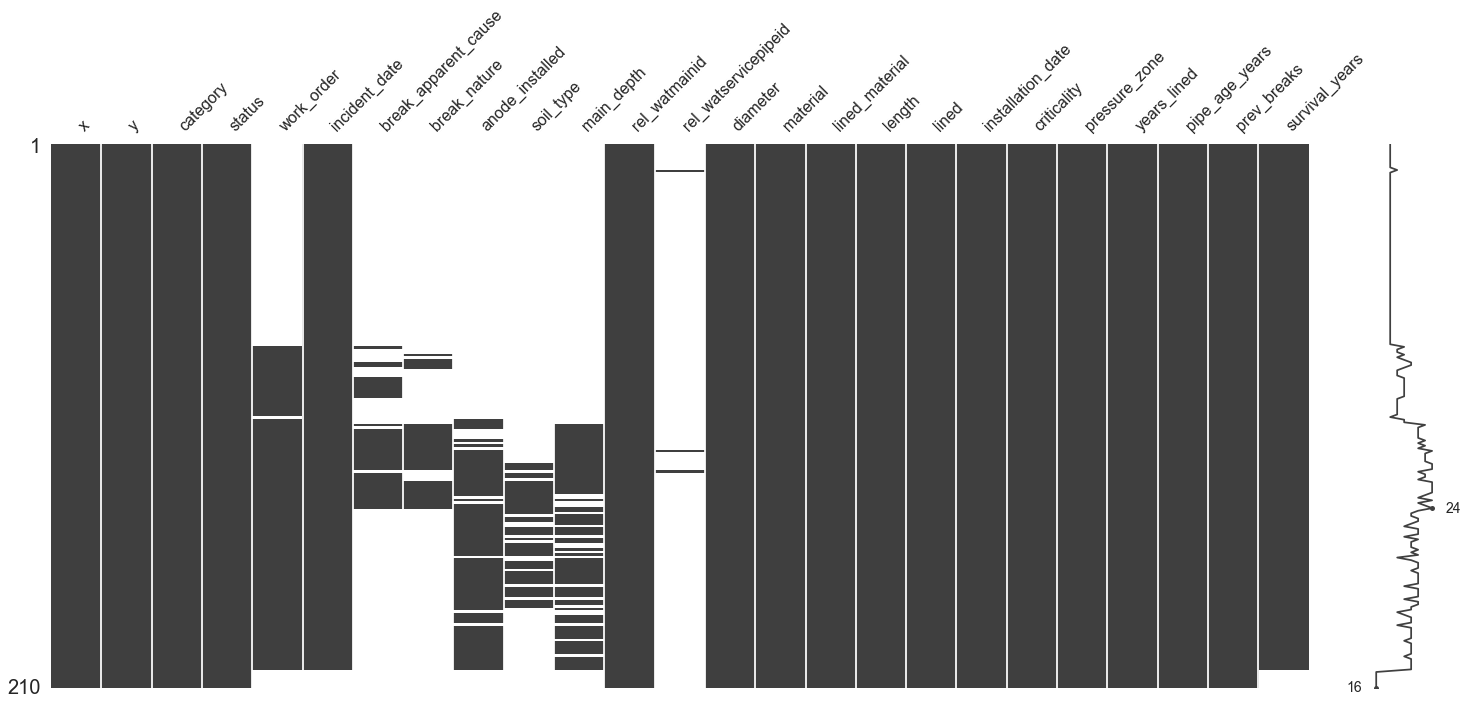

In [25]:
# This function visualizes the missing data in bar and sparkline format
msno.matrix(df_breaks)

### Why are there missing values in work_order?

In [26]:
print(df_breaks.work_order.unique().shape)
print(df_breaks.shape)

(120,)
(210, 25)


Since we can see there are 120 unique work orders for 203 pipes, and that the variable originally belonged to the
breaks dataset and not the watmain dataset, it cna be deduced that work_order is an identification number given
to individual repair jobs for watermain break occurences. 

The only reason I can see that work order might be missing is if it is related to the outcome of the repair job.

Text(0.5, 0, 'work_order is missing')

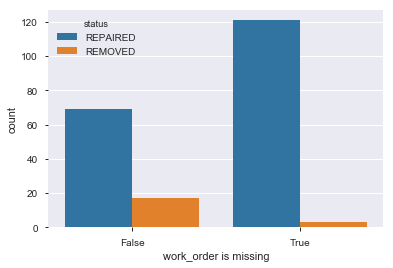

In [27]:
# Let us graph the relationship between the df_breaks.status and the missingness of df_breaks.work_order.

import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.countplot(hue=df_breaks.status, x=df_breaks.work_order.notnull())
plt.xlabel('work_order is missing')

Although it seems that there is a relationship between 'work_order' being missing and 'status' == REPAIRED, no
way to use this 'soft' relationship comes to mind. If there was a more obvious relationship, further investigation
could have been useful.

In [28]:
# We can, therefore, drop the work_order column.

df_breaks.drop(columns='work_order', inplace=True)

### Why are there missing values in incident_date?

In [29]:
df_breaks[df_breaks.incident_date.isnull()].T

,591,648,758,807,979,1793,2164
x,-80.5225,-80.4974,-80.494,-80.4144,-80.5002,-80.4227,-80.4834
y,43.4107,43.437,43.4393,43.4242,43.4573,43.4387,43.4343
category,MAIN,MAIN,MAIN,MAIN,MAIN,MAIN,MAIN
status,REPAIRED,REPAIRED,REPAIRED,REPAIRED,REPAIRED,REPAIRED,REPAIRED
incident_date,NaT,NaT,NaT,NaT,NaT,NaT,NaT
break_apparent_cause,NaN,NaN,NaN,NaN,NaN,NaN,NaN
break_nature,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anode_installed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
soil_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_depth,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Let us look at all break instances of the pipes that had a break isntance with a missing incident date.
no_inc_date_rel_watmainids = df_breaks[df_breaks.incident_date.isnull()].rel_watmainid
df_breaks[df_breaks.rel_watmainid.isin(no_inc_date_rel_watmainids)]

,x,y,category,status,incident_date,break_apparent_cause,break_nature,anode_installed,soil_type,main_depth,...,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
591,-80.522451,43.410701,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.00441314,NO,1999-06-01,0,KIT 5,0.0,19.6822,0,NaN
648,-80.497389,43.437016,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.000783011,NO,1985-01-01,5,KIT 4,0.0,34.1041,0,NaN
758,-80.494002,43.439300,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.00184813,NO,2005-10-01,7,KIT 4,0.0,13.3425,0,NaN
807,-80.414377,43.424159,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.0013164,NO,1976-12-01,6,KIT 4,0.0,42.1945,0,NaN
979,-80.500186,43.457319,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,4.17198e-05,NO,2004-07-20,5,KIT 4,0.0,14.5425,0,NaN
1793,-80.422749,43.438736,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.00539308,NO,1994-06-01,7,KIT 4,0.0,24.6849,0,NaN
2164,-80.483418,43.434342,MAIN,REPAIRED,NaT,NaN,NaN,NaN,NaN,NaN,...,NONE,0.000371196,NO,1975-01-01,6,KIT 4,0.0,44.1123,0,NaN


Now we are sure that that the break instances missing incident_date values were the only break instances of those
unique pipes.

In [31]:
print(df_breaks.shape)
df_breaks = df_breaks[~df_breaks.rel_watmainid.isin(no_inc_date_rel_watmainids)]
print(df_breaks.shape)

(210, 24)
(203, 24)


### Why are there missing values in break_apparent_cause

Since break_apparent_cause has so little data, lets just look at what the frequency of its values are

In [32]:
df_breaks.break_apparent_cause.value_counts()

KIT                                         7
CORROSION                                   5
AGE                                         4
Corrosion                                   3
SOILS                                       3
AGE & SOIL                                  3
Faulty Install                              2
AGE & CORROSSION                            2
NOT INDICATED                               2
Age/Corrosion                               2
Soils                                       1
FROZEN                                      1
AGE & CORROSION                             1
CORROSSION                                  1
OTHER                                       1
corrosion                                   1
AGE & PRESSURE                              1
Corrosion - Robar saddle corroded atseam    1
AGE CORROSION & SOILS                       1
Name: break_apparent_cause, dtype: int64

Since there is so little data here, and it doesn't give us clues as to how to impute the missing data, we can just drop this feature.

In [33]:
df_breaks.drop(columns='break_apparent_cause', inplace=True)

### Why are there missing values in break_nature

In [34]:
df_breaks.break_nature.value_counts()

CORROSION                                    6
Corrosion                                    4
Fitting/Joint                                4
Circumferential                              2
FITTING/JOINT                                2
corrosion                                    2
CIRCUMFERENTIAL                              2
CORROSION & FITTING/JOINT                    2
BELL JOINT                                   2
LONGITUDINAL                                 1
CORROSION, CIRCUMFERENTIAL, FITTING/JOINT    1
Water Service                                1
CORROSION - Robar Saddle Corroded at seam    1
CIRC CRACK                                   1
CORROSION & CIRCUMFERENTIAL                  1
CIRC-COR                                     1
LATITUDE                                     1
Name: break_nature, dtype: int64

Just like break_apparent_cause, there is very little data here. It doesn't give us any clues as to how to impute the missing data, so we can just drop this feature.

In [35]:
df_breaks.drop(columns='break_nature', inplace=True)

### Why are there missing values in anode_installed

In [36]:
df_breaks.anode_installed.value_counts()

YES                            50
yes                            16
NO                              8
Yes                             5
Blank                           1
1593 Highland Rd W              1
SILVERSPRING AT WARREN          1
302 COUNTRY HILL DR             1
N/A but 'NO' Node Installed     1
Oldmill Rd @ Syndenham St       1
no                              1
Name: anode_installed, dtype: int64

There is a fair amount of data in the anode_installed column. Let us see if there is any pattern in affirmative vs unaffirmative values.


In [37]:
# Create a temporary Dataframe with only the: int64, float64, and a boolean version of the anode_installed column.
anode_bool_col = df_breaks.anode_installed.isin(['Yes', 'YES', 'yes'])                                                
df_anode_installed_analysis = df_breaks.drop(columns=['rel_watmainid', 'rel_watservicepipeid']).select_dtypes(include=[np.int64, np.float64, np.datetime64]).join(anode_bool_col)
print(df_anode_installed_analysis.anode_installed.value_counts())

False    132
True      71
Name: anode_installed, dtype: int64


/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/numpy/lib/histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


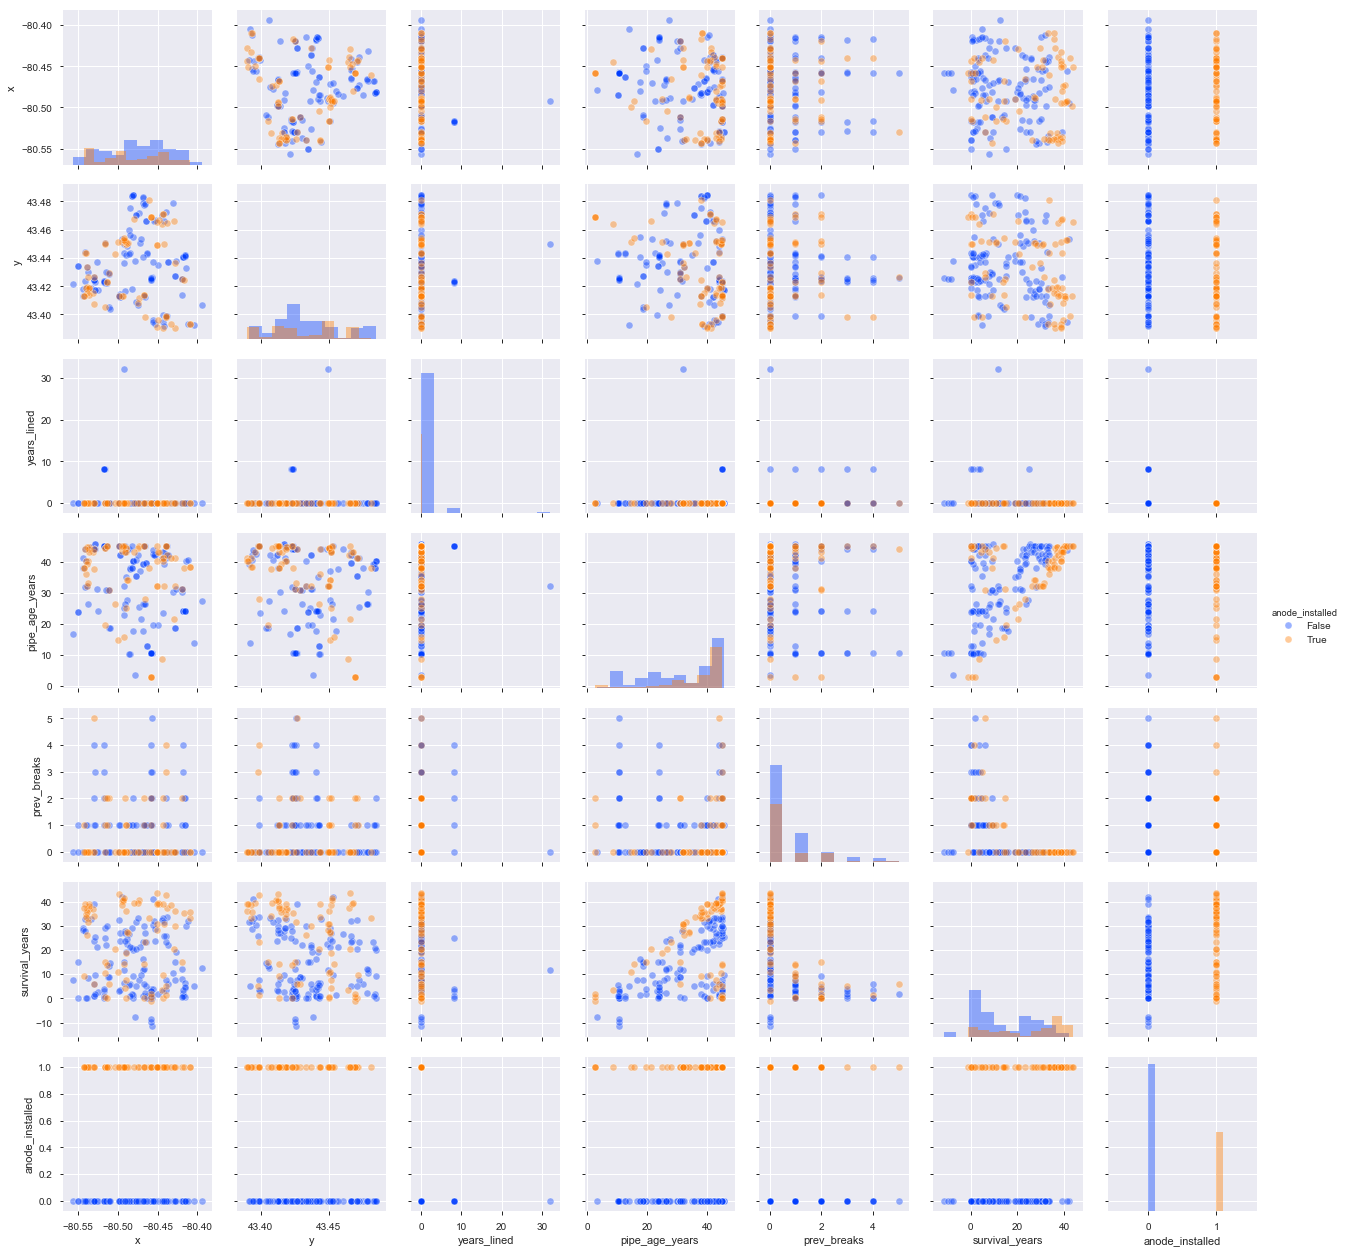

In [38]:
# Import Seaborn library and use the pairplot to do analysis
import seaborn as sns
sns.set_palette('bright')
sns.pairplot(df_anode_installed_analysis, hue='anode_installed', diag_kind='hist',
             plot_kws={'alpha':0.4}, diag_kws={'alpha':0.4})

Since the pipe_age_years vs survival_years scatterplot shows some interesting clusters, when we run our models, we will keep in mind imputing missing values in df_breaks.anode installed as 'No' (as we have done in df_anode_installed_analysis.anode_installed).

In [39]:
# Import pandas pipelines package
import pdpipe as pdp

# Define function to input as a pipeline stage
def cat_to_bool(df, col, true_vals):
                 df[col] = df[col].isin([true_vals])

# Indicate the true_vals argument for usage of the cat_to_bool() in our desired pipeline
yes_vals = ['YES', 'Yes', 'yes']

# Instantiate list of stages for our first pipeline
pipeline_1_stages = [pdp.AdHocStage(transform=cat_to_bool(df_breaks, 'anode_installed', yes_vals))]
pipeline_2_stages = [pdp.ColDrop('anode_installed')]

# Instantiate list of different pipelines to try out
diff_pipeline_stages_lst = [pipeline_1_stages, pipeline_2_stages]

/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/pdpipe/__init__.py:52: UserWarning: Traceback (most recent call last):
  File "/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/pdpipe/__init__.py", line 44, in <module>
    from . import sklearn_stages
  File "/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/pdpipe/sklearn_stages.py", line 6, in <module>
    from skutil.preprocessing import scaler_by_params
ModuleNotFoundError: No module named 'skutil'

  warnings.warn(tb)
/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/pdpipe/__init__.py:53: UserWarning: pdpipe: Scikit-learn import failed. Scikit-learn-dependent pipeline stages will not be loaded.
  warnings.warn("pdpipe: Scikit-learn import failed. Scikit-learn-dependent"
/Applications/anaconda3/envs/watmain_env/lib/python3.7/site-packages/pdpipe/__init__.py:68: UserWarning: Traceback (most recent call last):
  File "/Applications/anaconda3/envs/watmain_e

### Why are there missing values in soil_type?

In [40]:
df_breaks.soil_type.value_counts()

CLAY             16
GRAVEL           12
SAND              5
CLAY & GRAVEL     3
CLAY & SAND       3
SAND & GRAVEL     2
SILT              2
SILT & GRAVEL     1
Name: soil_type, dtype: int64

I could not find information online to indicate that there is a "default" soil type, so this column can be dropped
since it has so little data.

In [41]:
df_breaks.drop(columns='soil_type', inplace=True)

### Why are there missing values in main_depth?

In [42]:
df_breaks.main_depth.value_counts()

6'       18
7'       17
8'        7
6.5'      5
9'        4
5'        4
10'       3
2.5m      3
2m        2
-         1
2.2m      1
6' 6"     1
3'        1
52"       1
6.6'      1
2.1M      1
1.8m      1
6 ft      1
7.5'      1
5.5'      1
8 ft      1
4'        1
Name: main_depth, dtype: int64

It seems that these are recorded without any sort of pattern, therefore, it is likely that there is no default
value for the missing data in this column. We should, therefore, drop the column.

In [43]:
df_breaks.drop(columns='main_depth', inplace=True)

### Why are there missing values in rel_watservicepipeid?

 According to the Mariam Webbster online dictionary, a service pipe is:
     "a pipe connecting a main pipe (such as a gas or water main or an electrical conduit) with a building."

In [44]:
# Check to see if the rel_watservicepipeid values are also watermains in the dataset

df_breaks_OG = pd.read_csv(breaks_csv)
df_breaks[df_breaks.rel_watservicepipeid.isin([df_watmains.index, df_breaks_OG.REL_WATMAINID]) == True]

,x,y,category,status,incident_date,anode_installed,rel_watmainid,rel_watservicepipeid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years


Since we are sure that the rel_watservicepipeid values are not watermains, we can assume they are servicepipes. 
Maybe having a service pipe connected to a watermain could influence how soon that watermain breaks, so we can 
transform the 'rel_watservicepipeid' column into a boolean 'has_servicepipe' column.

In [45]:
df_breaks[df_breaks.rel_watservicepipeid.notnull() == True]

,x,y,category,status,incident_date,anode_installed,rel_watmainid,rel_watservicepipeid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
1555,-80.529779,43.424970,SERVICE,REPAIRED,1998-08-11,False,42320.0,4104575.0,200,DI - DUCTILE IRON,NONE,0.00276181,NO,1975-01-01,7,KIT 5,0.0,44.1123,0,23.6247
1922,-80.489541,43.449959,SERVICE,REPAIRED,2010-08-04,False,21560.0,4646730.0,300,DI - DUCTILE IRON,NONE,0.000546499,NO,1974-08-01,8,KIT 4,0.0,44.5315,0,36.0329
1476,-80.487683,43.450595,SERVICE,REPAIRED,2012-01-06,False,10330.0,4087857.0,200,DI - DUCTILE IRON,NONE,0.000775449,NO,1985-01-01,7,KIT 4,0.0,34.1041,0,27.0301


It seems that all rows that have rel_watservicepipeid values also have category=SERVICE. Let us see if the opposite is true.

In [46]:
df_breaks.category.value_counts()

MAIN       200
SERVICE      3
Name: category, dtype: int64

The opposite was true! Since we are now sure that rel_watservicepipeid is redundant, we can drop the column.

In [47]:
df_breaks.drop(columns='rel_watservicepipeid', inplace=True)

## Looking at outliers

In [48]:
col_list = df_breaks.columns.tolist()
len(col_list)

19

{'whiskers': [<matplotlib.lines.Line2D at 0x1249b1fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1249c17b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1249b1c50>],
 'medians': [<matplotlib.lines.Line2D at 0x1249c1eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1249c1e10>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x1249c7c18>,
 'caps': [<matplotlib.lines.Line2D at 0x1249c7fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1249c7898>],
 'medians': [<matplotlib.lines.Line2D at 0x1249d4a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1249d4da0>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x1249dd780>,
 'caps': [<matplotlib.lines.Line2D at 0x1249dde80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1249dd2e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1249e55c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1249e5940>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x1249e5d30>,
 'caps': [<matplotlib.lines.Line2D at 0x1249efa90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1249e5e10>],
 'medians': [<matplotlib.lines.Line2D at 0x1249eff60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1249f7550>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x1249f7e80>,
 'caps': [<matplotlib.lines.Line2D at 0x124a01630>,
 'boxes': [<matplotlib.lines.Line2D at 0x1249f79b0>],
 'medians': [<matplotlib.lines.Line2D at 0x124a01cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x124a01e10>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x124a0b9e8>,
 'caps': [<matplotlib.lines.Line2D at 0x124a0beb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x124a0b588>],
 'medians': [<matplotlib.lines.Line2D at 0x124a11828>],
 'fliers': [<matplotlib.lines.Line2D at 0x124a11ba8>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x124a11f98>,
 'caps': [<matplotlib.lines.Line2D at 0x124a1bc88>,
 'boxes': [<matplotlib.lines.Line2D at 0x124a1b1d0>],
 'medians': [<matplotlib.lines.Line2D at 0x124a263c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x124a26748>],
 'means': []}

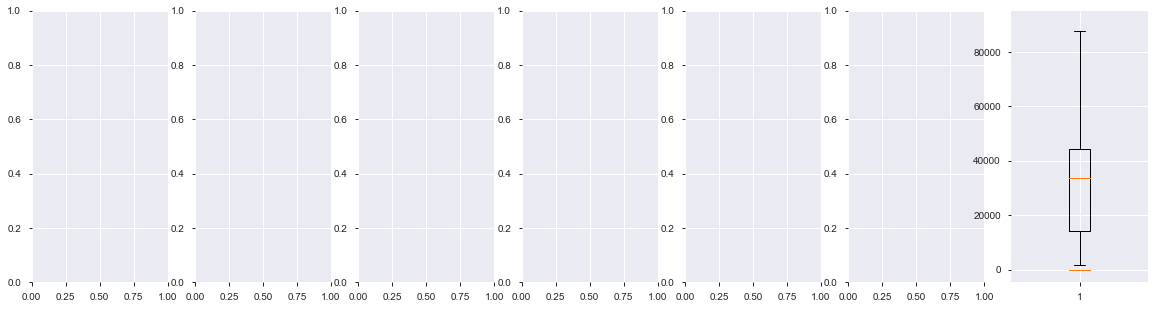

In [49]:

fig, axes = plt.subplots(ncols=7, figsize = (20,5))


for i, col in enumerate(df_breaks.select_dtypes(np.number).columns):
    plt.boxplot(df_breaks[col])
    #sns.boxplot(df_breaks[col])

#for col, ax in zip(u, axes):
#    df_breaks[col].boxplot(ax=ax)

In [50]:
# import matplotlib.pyplot as plt

# u = df_breaks.columns
# fig, axes = plt.subplots(ncols=len(u), figsize=(10,3))

# for column, ax in zip(u, axes):
#     df_breaks[df_breaks.columns==column].boxplot(x=df_breaks.column, title=column, ax =ax )

# plt.tight_layout()    

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

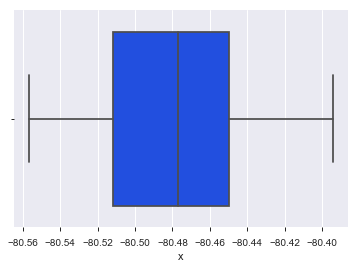

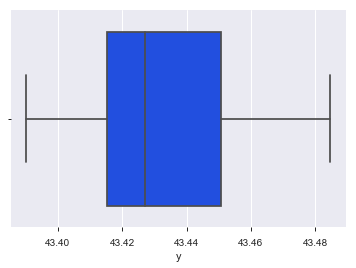

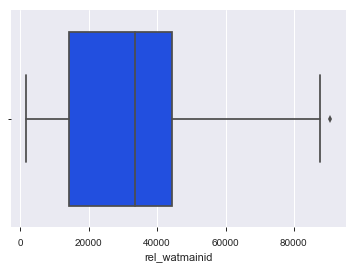

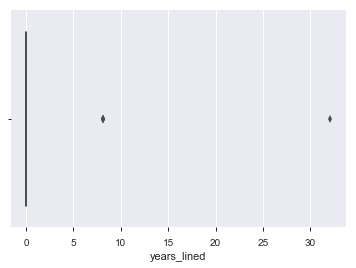

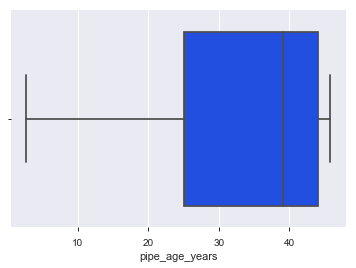

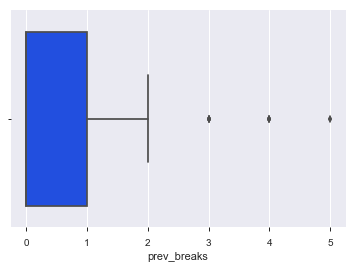

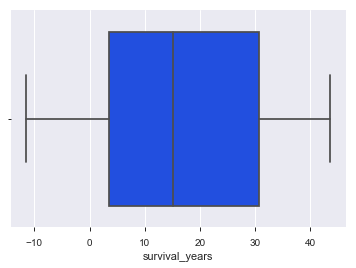

In [51]:
for i, col in enumerate(df_breaks.select_dtypes(np.number).columns):
    plt.figure(i)
    sns.boxplot(df_breaks[col])

Let's investigate the years_lined outliers.

In [52]:
df_breaks[df_breaks.years_lined > 5]

,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
1665,-80.492110,43.449738,MAIN,REPAIRED,1998-08-28,False,6890.0,600,DI - DUCTILE IRON,CEMENT,0.00279198,YES,1987-01-01,0,KIT 4,32.1041,32.1041,0,11.6630
2337,-80.516298,43.422493,MAIN,REMOVED,1998-11-01,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,0,24.8493
2302,-80.517241,43.423259,MAIN,REMOVED,2001-11-23,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,1,3.0630
2196,-80.517866,43.423764,MAIN,REMOVED,2002-11-26,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,2,1.0082
2074,-80.518060,43.423935,MAIN,REMOVED,2006-12-18,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,3,4.0630
1097,-80.516936,43.423012,MAIN,REMOVED,2007-03-16,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,4,0.2411


It seems that the years_lined outliers consist of a pipe that was lined at the same time it was built; and, a number of pipes that were lined at the same time. This seems to be sufficient explanation for these outliers.

Lets investigate the prev_breaks outliers.

In [53]:
df_breaks[df_breaks.prev_breaks > 2]

,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
425,-80.457141,43.425925,MAIN,REMOVED,1999-02-04,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0000,10.4740,3,0.0000
1928,-80.457642,43.425924,MAIN,REMOVED,1999-02-13,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0000,10.4740,4,0.0247
473,-80.417514,43.440551,MAIN,REPAIRED,1999-07-15,False,59020.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00129513,NO,1995-01-01,6,KIT 4,0.0000,24.0986,3,0.9452
1564,-80.457585,43.425893,MAIN,REMOVED,2001-01-06,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0000,10.4740,5,1.8986
1663,-80.529295,43.422850,MAIN,REPAIRED,2002-08-03,False,42320.0,200,DI - DUCTILE IRON,NONE,0.00276181,NO,1975-01-01,7,KIT 5,0.0000,44.1123,3,2.0000
1492,-80.417285,43.440452,MAIN,REPAIRED,2003-02-15,False,59020.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00129513,NO,1995-01-01,6,KIT 4,0.0000,24.0986,4,3.5918
2074,-80.518060,43.423935,MAIN,REMOVED,2006-12-18,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,3,4.0630
1795,-80.458265,43.425467,MAIN,REMOVED,2007-03-06,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0000,10.4740,3,3.0932
1097,-80.516936,43.423012,MAIN,REMOVED,2007-03-16,False,38850.0,150,CI - CAST IRON,EPS - EPOXY STRUCTURAL,0.00394195,YES,1974-01-01,5,KIT 5,8.1753,45.1123,4,0.2411
836,-80.529827,43.424473,MAIN,REPAIRED,2008-06-29,False,42320.0,200,DI - DUCTILE IRON,NONE,0.00276181,NO,1975-01-01,7,KIT 5,0.0000,44.1123,4,5.9096


Looking at the prev_breaks outliers, I noticed that there is an occurence of survival years = 0. This could be a break incident being duplicated. Lets see how many break incidents were duplicated.

In [54]:
# show any duplicates of incident date for each watmainid
temp = pd.concat(g for _, g in df_breaks.groupby("rel_watmainid") if len(g) > 1)
pd.concat(g for _, g in temp.groupby("incident_date") if len(g) > 1)[['incident_date', 'rel_watmainid', 'survival_years']]

,incident_date,rel_watmainid,survival_years
1642,1999-02-04,4710.0,1.1397
425,1999-02-04,4710.0,0.0000
793,2010-07-05,56110.0,15.1041
2332,2010-07-05,56110.0,0.0000
1202,2013-02-01,39770.0,26.2712
1199,2013-02-01,39770.0,0.0000
1125,2013-12-16,10110.0,34.9808
1123,2013-12-16,10110.0,0.0000


It looks like only four break instances were duplicated. Let us drop them.

In [55]:
# drop duplicated break instances 
df_breaks = df_breaks.drop(index = [425, 2332, 1199, 1123])

Lets investigate the negative values in survival years.

In [56]:
temp = df_breaks[df_breaks.survival_years < 0]
temp

,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
747,-80.457614,43.425909,MAIN,REPAIRED,1997-01-27,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.4740,0,-11.5507
1701,-80.458407,43.425075,MAIN,REMOVED,1999-01-09,False,7390.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00128464,NO,2008-08-13,6,KIT 4,0.0,10.4740,0,-9.6000
909,-80.458352,43.425297,MAIN,REMOVED,2000-02-08,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0,10.4740,0,-8.5178
1402,-80.478991,43.438099,MAIN,REPAIRED,2008-04-03,False,8490.0,300,DI - DUCTILE IRON,NONE,0.00082739,NO,2015-10-09,9,KIT 4,0.0,3.3151,0,-7.5205
34,-80.458343,43.469302,MAIN,REPAIRED,2015-03-14,False,81288.0,300,DI - DUCTILE IRON,NONE,0.00325005,NO,2016-05-25,7,KIT 4,0.0,2.6877,0,-1.2000


In [57]:
#display all break instances of each pipe with at least one negative surviival_years value

grouped = df_breaks[df_breaks.rel_watmainid.isin(temp.rel_watmainid)].groupby('rel_watmainid')

from IPython.display import display

for _,group in grouped: display(group)

,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
747,-80.457614,43.425909,MAIN,REPAIRED,1997-01-27,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.474,0,-11.5507
704,-80.457141,43.425925,MAIN,REMOVED,1997-12-15,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.474,1,0.8822
1642,-80.456507,43.426436,MAIN,REMOVED,1999-02-04,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.474,2,1.1397
1928,-80.457642,43.425924,MAIN,REMOVED,1999-02-13,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.474,4,0.0247
1564,-80.457585,43.425893,MAIN,REMOVED,2001-01-06,False,4710.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000134511,NO,2008-08-13,6,KIT 4,0.0,10.474,5,1.8986


,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
1701,-80.458407,43.425075,MAIN,REMOVED,1999-01-09,False,7390.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00128464,NO,2008-08-13,6,KIT 4,0.0,10.474,0,-9.6000
1435,-80.458360,43.424694,MAIN,REMOVED,2002-11-06,False,7390.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00128464,NO,2008-08-13,6,KIT 4,0.0,10.474,1,3.8274
1675,-80.457948,43.424074,MAIN,REMOVED,2003-02-17,False,7390.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.00128464,NO,2008-08-13,6,KIT 4,0.0,10.474,2,0.2822


,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
909,-80.458352,43.425297,MAIN,REMOVED,2000-02-08,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0,10.474,0,-8.5178
1519,-80.458161,43.425604,MAIN,REMOVED,2002-12-19,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0,10.474,1,2.8630
2028,-80.458441,43.425688,MAIN,REMOVED,2004-02-01,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0,10.474,2,1.1205
1795,-80.458265,43.425467,MAIN,REMOVED,2007-03-06,False,7400.0,150,PVC - POLYVINYL CHLORIDE,NONE,0.000735201,NO,2008-08-13,6,KIT 4,0.0,10.474,3,3.0932


,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
1402,-80.478991,43.438099,MAIN,REPAIRED,2008-04-03,False,8490.0,300,DI - DUCTILE IRON,NONE,0.00082739,NO,2015-10-09,9,KIT 4,0.0,3.3151,0,-7.5205


,x,y,category,status,incident_date,anode_installed,rel_watmainid,diameter,material,lined_material,length,lined,installation_date,criticality,pressure_zone,years_lined,pipe_age_years,prev_breaks,survival_years
34,-80.458343,43.469302,MAIN,REPAIRED,2015-03-14,False,81288.0,300,DI - DUCTILE IRON,NONE,0.00325005,NO,2016-05-25,7,KIT 4,0.0,2.6877,0,-1.2000
124,-80.458590,43.469220,MAIN,REPAIRED,2015-07-23,False,81288.0,300,DI - DUCTILE IRON,NONE,0.00325005,NO,2016-05-25,7,KIT 4,0.0,2.6877,1,0.3589
263,-80.458658,43.469198,MAIN,REPAIRED,2017-06-28,False,81288.0,300,DI - DUCTILE IRON,NONE,0.00325005,NO,2016-05-25,7,KIT 4,0.0,2.6877,2,1.9342


The negative value seems to be an installation_date data entry error. Since many features were engineered using the installation_date feature, we should delete these pipes from the data set.

In [58]:
lst = []
for a,b in grouped: 
    lst.append(a)

df_breaks = df_breaks[~df_breaks['rel_watmainid'].isin(lst)]

Finally, we clean the categorical values to be shorter.

In [59]:
# cleaning values in categorical features
df_breaks['lined_material'].replace('EPS - EPOXY STRUCTURAL', 'EPS', inplace = True)
df_breaks['lined'].replace(['f', 't'], [0, 1], inplace = True)
df_breaks['material'].replace(['CI - CAST IRON', 'DI - DUCTILE IRON', 'PVC - POLYVINYL CHLORIDE', 'AC - ASBESTOS CEMENT',
                           'CPP - CONCRETE PRESSURE PIPE', 'COP - COPPER', 'HDPE - HIGH DENSITY POLYETHYLENE'],
                          ['CI', 'DI', 'PVC', 'AC', 'CPP', 'COP', 'HDPE'], inplace = True)

# Exploratory Data Analysis

In [60]:
#sns.pairplot(df_breaks.select_dtypes(np.number).join(df_breaks.material), hue='material', diag_kind='hist',
#             plot_kws={'alpha':0.4}, diag_kws={'alpha':0.4})

# Machine Learning Classification

## Feature engineering to make the probleminto a classification task

In [61]:
df_breaks_ML = df_breaks

In [62]:
df_breaks_ML['survival_years_under_2'] = df_breaks_ML.survival_years < 2

In [63]:
# one-hot-encode categorical variables
df_breaks_ML = pd.get_dummies(df_breaks_ML, columns=['category','material', 'lined_material', 'pressure_zone', 'lined'])
# drop features that are now irrelevant due to previous feature engineering
df_breaks_ML = df_breaks_ML.drop(columns = ['lined_material_NONE'])

In [64]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split, KFold, cross_val_score

labels = df_breaks_ML.survival_years_under_2
features = df_breaks_ML.drop(columns = ['survival_years_under_2','survival_years', 'incident_date', 'installation_date', 'status'])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = {
    'KNN':KNeighborsClassifier(3),
    'SVC':SVC(kernel="rbf", C=0.025, probability=True),
    'DTC':DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()}

SyntaxError: invalid syntax (<ipython-input-65-ec33bd952b53>, line 13)

In [ ]:
def cross_validate_models(models, train_features, train_labels):
    kf = KFold(n_splits = 10)
    for model in models:
        error = cross_val_score(model, train_features, train_labels, cv=kf, scoring='accuracy')
       # acc_score = (np.mean(error))
        print(f'{model} accuracy: {acc_score: 0.4f}\n')

In [ ]:
cross_validate_models(models, train_features, train_labels)

# Machine Learning

In [ ]:
# cleaning values in categorical features
df_breaks['lined_material'].replace('EPS - EPOXY STRUCTURAL', 'EPS', inplace = True)
df_breaks['lined'].replace(['f', 't'], [0, 1], inplace = True)
df_breaks['material'].replace(['CI - CAST IRON', 'DI - DUCTILE IRON', 'PVC - POLYVINYL CHLORIDE', 'AC - ASBESTOS CEMENT',
                           'CPP - CONCRETE PRESSURE PIPE', 'COP - COPPER', 'HDPE - HIGH DENSITY POLYETHYLENE'],
                          ['CI', 'DI', 'PVC', 'AC', 'CPP', 'COP', 'HDPE'], inplace = True)

In [ ]:
# one-hot-encode categorical variables
df_breaks = pd.get_dummies(df_breaks, columns=['category','material', 'lined_material', 'pressure_zone', 'lined'])
# drop features that are now irrelevant due to previous feature engineering
df_breaks = df_breaks.drop(columns = ['lined_material_NONE'])

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split, KFold, cross_val_score

labels = df_breaks.survival_years
features = df_breaks.drop(columns = ['survival_years', 'incident_date', 'installation_date', 'status'])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

import seaborn as sns

models = {
    'RFR': RandomForestRegressor(n_estimators=50, random_state=0),
    'GBR': GradientBoostingRegressor(max_depth=1, random_state=0),
    'LR': LinearRegression(),
    'SVR': SVR(kernel='linear')
}

modelscompared = {}
def cross_validate_models(models, train_features, train_labels):
    kf = KFold(n_splits = 10)
    for name, model in models.items():
        error = cross_val_score(model, train_features, train_labels, cv=kf, scoring='neg_mean_squared_error')
        RMSE = (-1*np.mean(error))**(1/2)
        print(f'{name} RMSE: {RMSE: 0.4f}')
    modelscompared.update({'model.str':RMSE} )
    modelscompared.sort('RMSE')

In [ ]:
cross_validate_models(models, train_features, train_labels)

In [ ]:
cols = ['diameter', 'length', 'criticality']

for col in cols:
    df_breaks[col] = pd.to_numeric(df_breaks[col])

In [ ]:
df_breaks.info()